In [21]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
import scipy.sparse as sp
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

plt.rcParams['font.size'] = 12

# Load data

In [22]:
sp_data = sc.read('../datas/mouse_visual_cortex/seqfish+_spatial.h5ad')
sp_data

AnnData object with n_obs × n_vars = 524 × 10000
    obs: 'celltype'
    var: 'n_cells'
    obsm: 'spatial'

In [23]:
sc_data = sc.read('../datas/mouse_visual_cortex/smart_seq2_scrna.h5ad')
sc_data

AnnData object with n_obs × n_vars = 14249 × 34041
    obs: 'subclass', 'celltype'

# Process data

In [24]:
# Convert to row-sparse matrix
if not sp.issparse(sc_data.X):
    sc_data.X = sp.csr_matrix(sc_data.X)
    
if not sp.issparse(sp_data.X):
    temp = sp.csr_matrix(np.array(sp_data.X)).copy()
    del sp_data.X
    sp_data.X = temp.copy()
    del temp

In [25]:
# # Find common cell types
common_cell_type = list(set(sp_data.obs['celltype'].tolist()) & set(sc_data.obs['celltype'].tolist()))
common_cell_type

['ExcitatoryL5and6',
 'Olig',
 'ExcitatoryL4',
 'Endo',
 'Astro',
 'ExcitatoryL2and3',
 'Inhibitory',
 'Micro']

In [26]:
sc_data.obs['cell_type'] = sc_data.obs['celltype']
sp_data.obs['cell_type'] = sp_data.obs['celltype']

In [27]:
sp_data = sp_data[sp_data.obs['cell_type'].isin(common_cell_type), :]
sp_data

View of AnnData object with n_obs × n_vars = 497 × 10000
    obs: 'celltype', 'cell_type'
    var: 'n_cells'
    obsm: 'spatial'

In [28]:
sc_data = sc_data[sc_data.obs['cell_type'].isin(common_cell_type), :]
sc_data

View of AnnData object with n_obs × n_vars = 14088 × 34041
    obs: 'subclass', 'celltype', 'cell_type'

In [29]:
# Please make sure cell_type is included in scRNA_data.obs
assert 'cell_type' in sc_data.obs

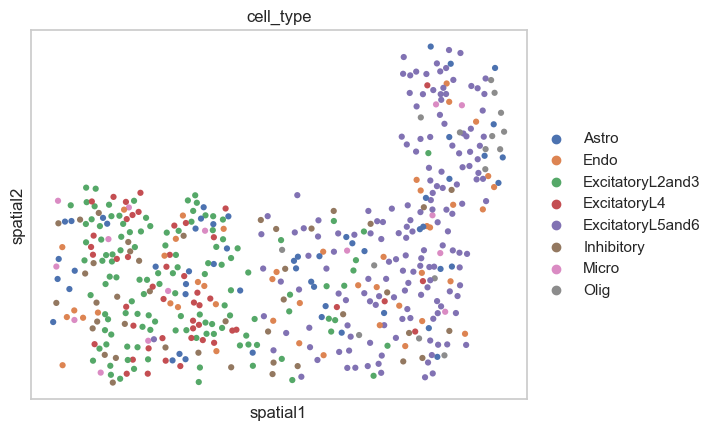

In [30]:
sc.pl.embedding(sp_data, basis='spatial', color='cell_type', size=80)

In [31]:
cell_type_palette = {
    'Astro': '#4c72b0',
     'Endo': '#dd8452',
     'ExcitatoryL2and3': '#55a868',
     'ExcitatoryL4': '#c44e52',
     'ExcitatoryL5and6': '#8172b3',
     'Inhibitory': '#937860',
     'Micro': '#da8bc3',
     'Olig': '#8c8c8c'
}

# Run code

In [32]:
import sys
sys.path.append('../')

import SpCAST
from SpCAST.utils import preprocess_datasets

In [33]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

del scRNA_data.raw
del spRNA_data.raw

In [34]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

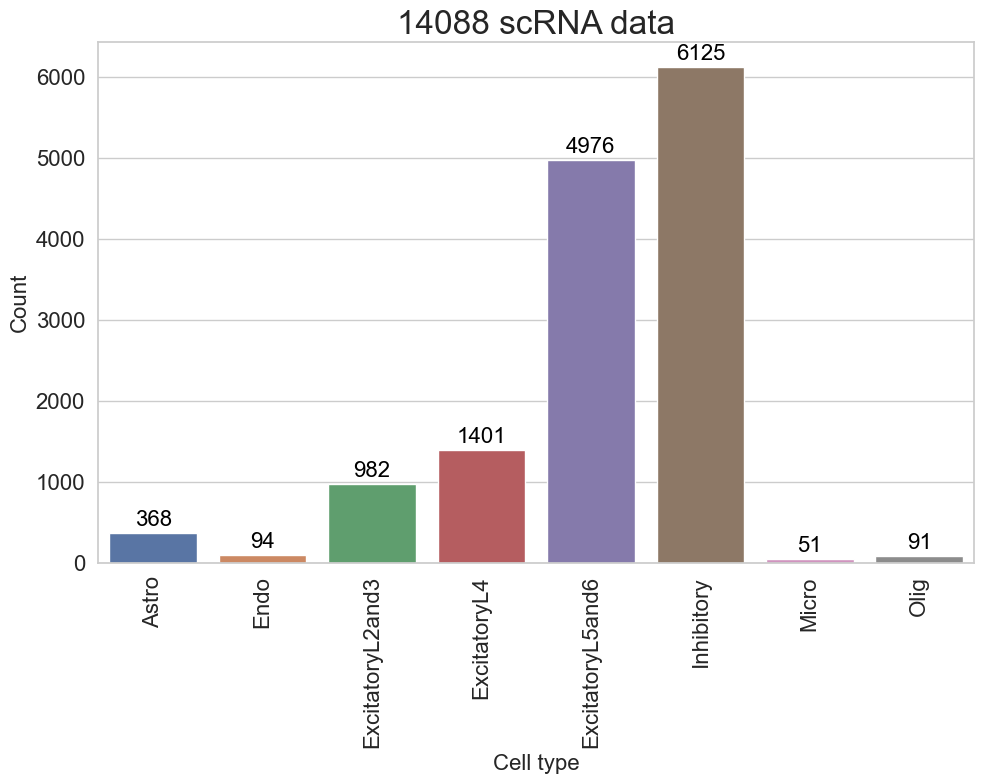

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Calculate the count for each category
sc_category_counts = scRNA_data.obs['cell_type'].value_counts().reset_index()
sc_category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10, 8))

# Draw barplot
ax = sns.barplot(x='Category', y='Count', data=sc_category_counts)

# Add title and labels
plt.title(f'{len(scRNA_data.obs)} scRNA data', fontsize=24)
plt.xlabel('Cell type', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=16)

# Increase font size for y-axis ticks
plt.yticks(fontsize=16)

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=16, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [36]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

del scRNA_data.raw
del spRNA_data.raw

In [37]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

datatype = 'FISH'
assert datatype in ['FISH', 'Seq']
scRNA_data, spRNA_data = preprocess_datasets(scRNA_data, spRNA_data, final_n_top_genes=500, min_genes_in_cells=3, datatype=datatype)

Preprocessing scRNA-seq data ...
scRNA Data before filtering: 14088 cells  ||  scRNA Data after filtering: 14088 cells
Normalizing and log1p raw scRNA counts...
sc data nonzero expression ratio: 26.27%
-----------------------------------------------
Preprocessing spRNA-seq data ...
Normalizing and log1p raw spRNA counts...
-----------------------------------------------
sp data nonzero expression ratio: 33.44%
Concatenating datasets...
We have 9659 shared genes on scRNA and spatial RNA data
Computing scRNA data marker genes ...
We ultimately use 615 genes for training ...
Preprocessing completed...


In [40]:
save_model_path='../model'
save_model_name='model_params.pth'

prob_df = SpCAST.train_SpCAST(scRNA_data=scRNA_data, spRNA_data=spRNA_data,
                              latent_dim1=30, latent_dim2=20, 
                              batch_size=256, loss_step=5, n_epochs=30, device=device, 
                              save_model_path=save_model_path, save_model_name=save_model_name)

Size of scRNA-seq data Input:  (14088, 615)
Size of spRNA-seq data Input:  (497, 615)
Class distribution: [ 368   94  982 1401 4976 6125   51   91]
Class weights: [0.12274697 0.15932191 0.10529292 0.10013344 0.08523058 0.08320041
 0.18362126 0.16045252]
Train the model..........


Training:  23%|█████████████████                                                        | 7/30 [00:00<00:01, 13.20it/s]

Epoch:5 MMD Loss:0.082  Class Loss:3.173  Recon loss: 107.845  Train_Accuracy: 71.48% 


Training:  43%|███████████████████████████████▏                                        | 13/30 [00:00<00:01, 15.24it/s]

Epoch:10 MMD Loss:0.138  Class Loss:1.929  Recon loss: 113.109  Train_Accuracy: 75.78% 


Training:  57%|████████████████████████████████████████▊                               | 17/30 [00:01<00:00, 15.58it/s]

Epoch:15 MMD Loss:0.201  Class Loss:1.061  Recon loss: 121.343  Train_Accuracy: 81.84% 


Training:  77%|███████████████████████████████████████████████████████▏                | 23/30 [00:01<00:00, 16.09it/s]

Epoch:20 MMD Loss:0.237  Class Loss:0.663  Recon loss: 128.924  Train_Accuracy: 90.82% 


Training:  90%|████████████████████████████████████████████████████████████████▊       | 27/30 [00:01<00:00, 16.34it/s]

Epoch:25 MMD Loss:0.193  Class Loss:0.473  Recon loss: 122.501  Train_Accuracy: 96.29% 


Training: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.72it/s]


Epoch:30 MMD Loss:0.164  Class Loss:0.286  Recon loss: 108.596  Train_Accuracy: 99.02% 
Testing the model..........


Testing scRNA data: 100%|█████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 155.99it/s]


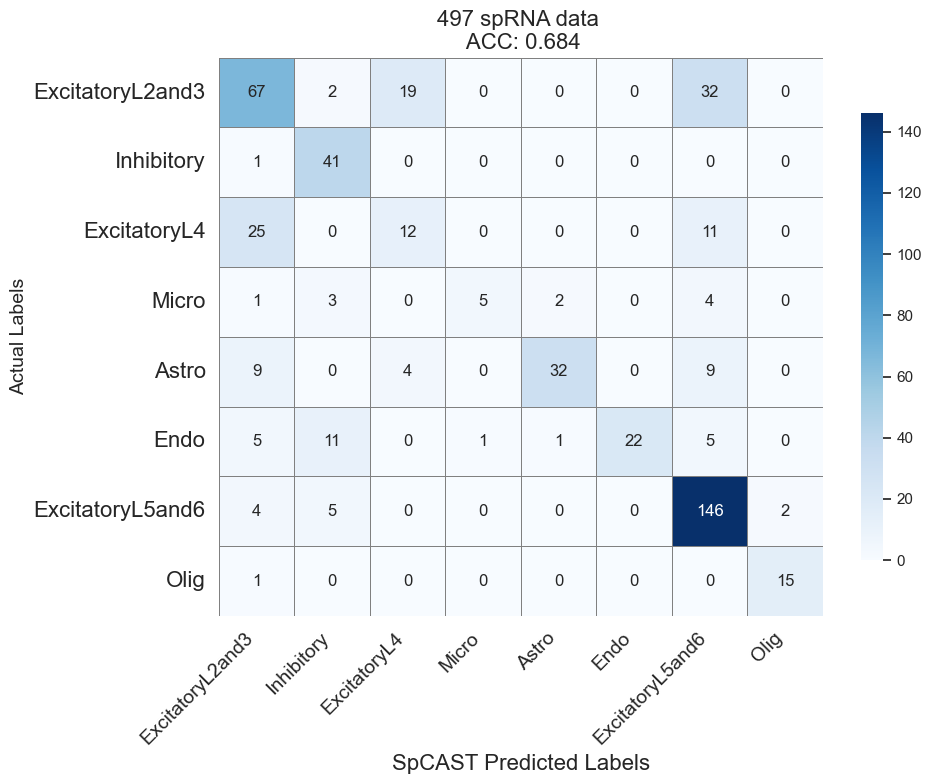

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Get unique category labels
cell_labels = spRNA_data.obs['cell_type'].unique().tolist()

spRNA_data.obs.cell_type = spRNA_data.obs.cell_type.astype(str)
spRNA_data.obs.SpCAST_predicted = spRNA_data.obs.SpCAST_predicted.astype(str)

# Calculate confusion matrix
conf_matrix = confusion_matrix(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], labels=cell_labels)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=cell_labels, columns=cell_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))  # Increase figure size
sns.heatmap(conf_matrix_df, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar_kws={'shrink': 0.8},  # Shrink color bar
            linewidths=0.5,  # Add grid line width
            linecolor='grey')  # Set grid line color

# Add axis labels and title
plt.xlabel('SpCAST Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=16)  # Keep y-axis labels horizontal

# Calculate accuracy and update the title
accuracy = accuracy_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'])
f1 = f1_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], average='macro')

plt.title(f'{len(spRNA_data.obs)} spRNA data \n ACC: {accuracy:.3f}', fontsize=16)
# Display the plot
plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure
plt.show()